In [6]:
# Author: Salil Kamath
# Analysis of bankruptcy data. 
# Source: https://www.kaggle.com/fedesoriano/company-bankruptcy-prediction

# Imports for all libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.utils import resample
from tensorflow import keras
from tensorflow.keras import layers
from IPython import display

In [7]:
#Get data mounted in drive
df = pd.read_csv("https://github.gatech.edu/raw/skamath36/Databiz/master/data.csv?token=AAALH5QMUHHU6HWLQ7IJXIDAV7UBS")
df

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.000000e+00,0.458143,7.250725e-04,0.000000,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,...,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,2.559237e-02,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.000000e+00,0.461867,6.470647e-04,0.000000,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,...,0.182419,0.014948,0.004136,1.383910e-03,0.056963,0.341106,0.289642,0.005210,0.308589,0.731975,0.329740,2.394682e-02,0.931065,0.002226,0.025516,1.065198e-04,7.700000e+09,0.593916,2.490000e+09,0.671570,0.468828,0.308589,0.329740,0.120916,0.641100,0.459001,0.567101,0.314163,0.047775,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,2.361297e-04,2.550000e+07,0.458521,7.900790e-04,0.000000,0.177911,0.177911,0.193713,0.180581,0.307102,0.005944,0.092338,0.142803,0.022760,0.848094,0.689463,0.689470,0.217601,7.280000e+09,0.000396,0.264184,0.368913,0.011543,0

In [8]:
# Drop all null, NAN rows. No columns have significant large numbers of empty values.
df = df.dropna(axis = 0, how='any')
df.isnull().sum()
df = df.drop([' Net Income Flag'], axis=1)

In [9]:
# Split data into train and test sets.
X = df.drop(columns=['Bankrupt?'])
Y = df['Bankrupt?']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle=True)
print("Training X set shape: ", X_train.shape)
print("Testing X set shape: ", X_test.shape)
print("Training Y set shape: ", Y_train.shape)
print("Testing Y set shape: ", Y_test.shape)

Training X set shape:  (4773, 94)
Testing X set shape:  (2046, 94)
Training Y set shape:  (4773,)
Testing Y set shape:  (2046,)


In [10]:
# Fix skew in data by Resample 
# Uses undersampling
train_data = pd.concat([X_train, Y_train], axis = 1)
bankrupt = train_data[train_data['Bankrupt?'] == 1]
not_bankrupt = train_data[train_data['Bankrupt?'] == 0]
pop_upsampled = resample(bankrupt, replace = True, n_samples=len(not_bankrupt), random_state=37)
upsampled = pd.concat([not_bankrupt, pop_upsampled])
upsampled['Bankrupt?'].value_counts()

1    4614
0    4614
Name: Bankrupt?, dtype: int64

In [11]:
# Use upsampled data
X_train, X_test, Y_train, Y_test = train_test_split(upsampled.drop(columns='Bankrupt?'), upsampled['Bankrupt?'], test_size=0.3, shuffle=True)
print("Upsampled Training X set shape: ", X_train.shape)
print("Upsampled Testing X set shape: ", X_test.shape)
print("Upsampled Training Y set shape: ", Y_train.shape)
print("Upsampled Testing Y set shape: ", Y_test.shape)

Upsampled Training X set shape:  (6459, 94)
Upsampled Testing X set shape:  (2769, 94)
Upsampled Training Y set shape:  (6459,)
Upsampled Testing Y set shape:  (2769,)


In [12]:
# Scale training data so that each column has mean 0 and standard deviation of 1.
# Fit to training data only.
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
X_train

array([[-6.41590920e-02,  1.74951730e-02, -4.79806423e-02, ...,
        -7.68650935e-02, -2.08408994e-01, -2.69292564e-01],
       [-1.58371280e+00, -1.33620038e+00, -1.52119097e+00, ...,
        -5.47531699e-02, -5.35985631e-03, -2.99887840e-01],
       [-9.56110143e-01, -4.42089532e-01, -6.49118191e-01, ...,
        -6.30483368e-02, -6.45866636e-02, -3.68523965e-01],
       ...,
       [-1.19228535e+00, -9.70985156e-01, -1.12688345e+00, ...,
        -5.38765249e-02,  9.39154862e-05,  5.57274481e-01],
       [-9.30334675e-01, -9.19268547e-01, -1.02709703e+00, ...,
        -6.12448921e-02, -5.04022862e-02, -3.03411751e-01],
       [-1.27698616e-01,  6.76122986e-02, -9.39428694e-02, ...,
        -8.32956009e-02, -3.07722877e-01, -4.13813656e-01]])

In [14]:
X_test

array([[-0.26137139, -0.0155608 , -0.15018612, ..., -0.05800954,
        -0.02686529, -0.25961607],
       [ 0.57723044,  0.54105919,  0.46304675, ..., -0.05213372,
         0.0105473 , -0.00123948],
       [ 0.4279725 ,  0.33259327,  0.38987005, ..., -0.03345088,
         0.09764774,  0.12889442],
       ...,
       [ 0.22476591,  0.41256741,  0.31911241, ..., -0.05336571,
         0.00321037,  1.10082866],
       [-0.16366438, -0.00809655, -0.12962407, ..., -0.07190478,
        -0.14818824, -0.37294737],
       [-0.12290318,  0.04521954, -0.04556158, ..., -0.07567277,
        -0.19283134, -0.26470157]])

In [15]:
Y_train

1537    0
4680    1
2026    1
6064    0
715     1
       ..
1055    0
5638    0
6473    0
5       1
379     1
Name: Bankrupt?, Length: 6459, dtype: int64

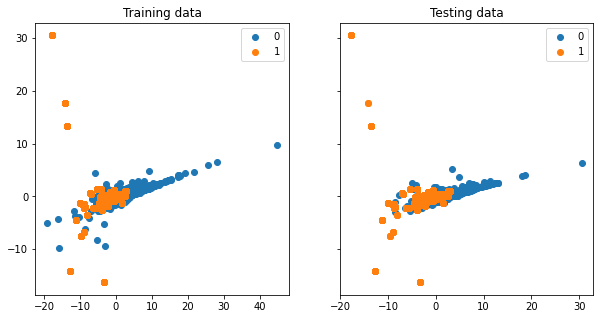

In [16]:
# Perform PCA using 2 components
pca = PCA(n_components=2)
pca.fit(X_train)
X_train2D = pca.transform(X_train)
X_test2D = pca.transform(X_test)
f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(10,5))
for i in range(2):
  axarr[0].scatter(X_train2D[Y_train == i, 0], X_train2D[Y_train == i, 1], label = str(i))
  axarr[0].legend()
  axarr[0].set_title('Training data')

  axarr[1].scatter(X_test2D[Y_test == i, 0], X_test2D[Y_test == i, 1], label = str(i))
  axarr[1].legend()
  axarr[1].set_title('Testing data')

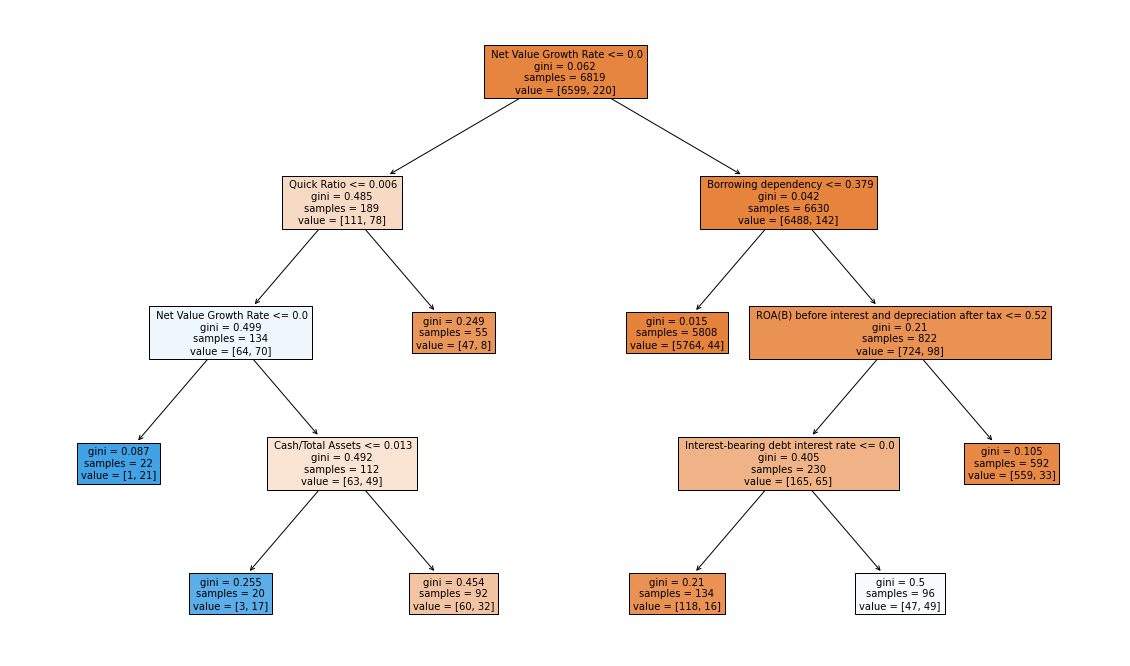

Decision tree training accuracy:  0.4965164886205295
Decision tree testing accuracy:  0.49259660527266164


In [17]:
# Decision tree model
clf_tree = tree.DecisionTreeClassifier(max_leaf_nodes = 8, random_state=0)
clf_tree.fit(X, Y)
plt.figure(figsize = (20, 12))
tree.plot_tree(clf_tree, filled=True, fontsize=10,feature_names = list(X.columns))
plt.show()
print("Decision tree training accuracy: ", clf_tree.score(X_train, Y_train))
print("Decision tree testing accuracy: ", clf_tree.score(X_test, Y_test))

In [18]:
# Logistic Regression Model
logmodel = LogisticRegression(max_iter=10000, random_state=0)
logmodel.fit(X_train, Y_train)
predictions = logmodel.predict(X_test)
print("Logistic Regression Training Accuracy: ", logmodel.score(X_train, Y_train))
print("Logisic Regression Testing Accuracy: ", logmodel.score(X_test, Y_test))

Logistic Regression Training Accuracy:  0.8933271404242142
Logisic Regression Testing Accuracy:  0.8905742145178764


In [19]:
# Neural Network
nn = MLPClassifier(max_iter = 10000, solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(3,5), random_state=0)
nn.fit(X_train, Y_train)
print('Neural Network Training Accuracy: ', nn.score(X_train, Y_train))
print('Neural Network Testing Accuracy: ', nn.score(X_test, Y_test))


Neural Network Training Accuracy:  0.9667131134850596
Neural Network Testing Accuracy:  0.9584687612856627


In [20]:
# Linear Support Vector Machine
linear_svm = SVC(kernel='linear', random_state=0)
linear_svm.fit(X_train, Y_train)

print('Linear SVM Training Accuracy: ', linear_svm.score(X_train, Y_train))
print('Linear SVM Testing Accuracy: ', linear_svm.score(X_test, Y_test))


Linear SVM Training Accuracy:  0.9023068586468493
Linear SVM Testing Accuracy:  0.905742145178765


In [21]:
# Kernel SVM
svm_rbf = SVC(kernel='rbf', random_state=0)
svm_rbf.fit(X_train, Y_train)

print('Kernel SVM Training Accuracy: ', svm_rbf.score(X_train, Y_train))
print('Kernel SVM Testing Accuracy: ', svm_rbf.score(X_test, Y_test))

Kernel SVM Training Accuracy:  0.9538628270630128
Kernel SVM Testing Accuracy:  0.9544962080173348


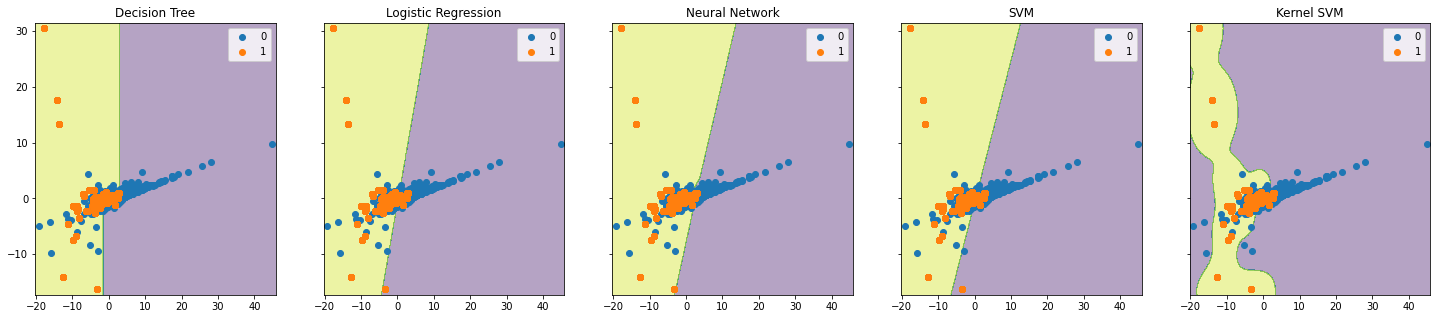

In [22]:
# Visualize results
def plot_boundary(X, Y):
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
  f, axarr = plt.subplots(1, 5, sharex='col', sharey='row', figsize=(25, 5))
  for idx, clf, tt in zip([0, 1, 2, 3, 4], list(models.values()), list(models.keys())):
    clf.fit(X, Y)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axarr[idx].contourf(xx, yy, Z, alpha=0.4)
    for i in range(2):
      axarr[idx].scatter(X[Y == i, 0], X[Y == i, 1], label=str(i))
    axarr[idx].legend()
    axarr[idx].set_title(tt)
models = {'Decision Tree' : clf_tree, 'Logistic Regression' : logmodel, 'Neural Network' : nn, 'SVM' : linear_svm, 'Kernel SVM' : svm_rbf}
plot_boundary(X_train2D, Y_train)

Decision Tree:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90      1395
           1       0.87      0.94      0.90      1374

    accuracy                           0.90      2769
   macro avg       0.90      0.90      0.90      2769
weighted avg       0.90      0.90      0.90      2769

Logistic Regression:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1395
           1       0.88      0.90      0.89      1374

    accuracy                           0.89      2769
   macro avg       0.89      0.89      0.89      2769
weighted avg       0.89      0.89      0.89      2769

Neural Network:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      1395
           1       0.92      1.00      0.96      1374

    accuracy                           0.96      2769
   macro avg       0.96      0.96      0.96      2769
weighted avg       0.9

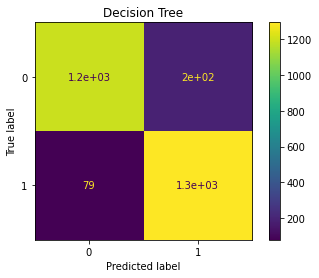

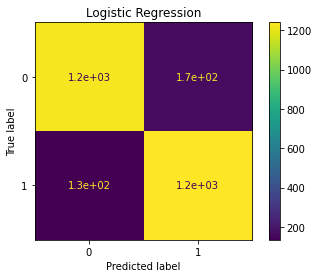

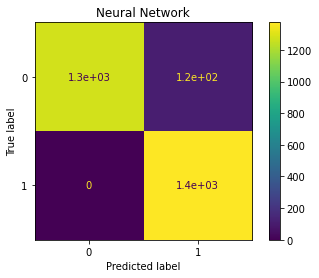

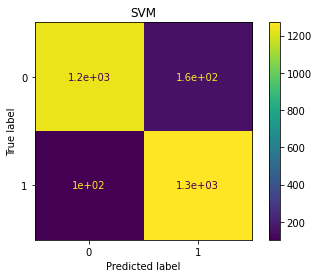

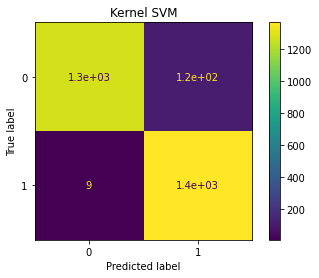

In [23]:
# Evaluation of classifiers
# Print Classification Reports
# Display confusion matrices
predicts = {}
for model_name in models:
  model = models[model_name]
  model.fit(X_train, Y_train)
  Y_pred = model.predict(X_test)
  predicts[model_name] = Y_pred
  print(model_name + ':')
  print(classification_report(Y_test, Y_pred))

  plot_confusion_matrix(models[model_name], X_test, Y_test)
  plt.title(model_name)


In [24]:
# Deep learning
# Define model based on shape
model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=[94]),
    layers.Dense(512, activation='relu'),                  
    layers.Dense(512, activation='relu'),
    layers.Dense(1)    
])

In [25]:
# Compile optimizer and loss functions
# Uses stochastic gradient descent
# Display accuracy and loss for each epoch
model.compile(
    optimizer='adam',
    loss='mae',
    metrics=['accuracy']
)

history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    batch_size=256,
    epochs=10,
)

Epoch 1/10
26/26 [==============================] - 2s 37ms/step - loss: 0.3863 - accuracy: 0.7906 - val_loss: 0.1559 - val_accuracy: 0.9126
Epoch 2/10
26/26 [==============================] - 1s 28ms/step - loss: 0.1465 - accuracy: 0.9256 - val_loss: 0.1075 - val_accuracy: 0.9520
Epoch 3/10
26/26 [==============================] - 1s 29ms/step - loss: 0.0986 - accuracy: 0.9606 - val_loss: 0.0853 - val_accuracy: 0.9711
Epoch 4/10
26/26 [==============================] - 1s 29ms/step - loss: 0.0885 - accuracy: 0.9672 - val_loss: 0.0705 - val_accuracy: 0.9780
Epoch 5/10
26/26 [==============================] - 1s 28ms/step - loss: 0.0725 - accuracy: 0.9753 - val_loss: 0.0665 - val_accuracy: 0.9812
Epoch 6/10
26/26 [==============================] - 1s 28ms/step - loss: 0.0701 - accuracy: 0.9766 - val_loss: 0.0616 - val_accuracy: 0.9801
Epoch 7/10
26/26 [==============================] - 1s 29ms/step - loss: 0.0586 - accuracy: 0.9836 - val_loss: 0.0556 - val_accuracy: 0.9892
Epoch 8/10
26

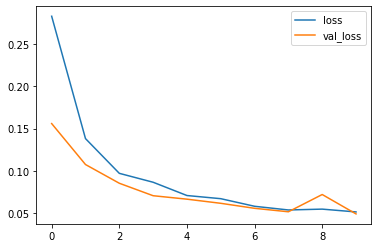

In [26]:
# Plot history
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot();